# An introduction to Logistic Regression

This notebook is a brief explanation of how we can build a linear Machine Learning model in Python using [scikit-learn](http://scikit-learn.org). If you are unfamiliar with Logistic Regression, you can start by reading on [Wikipedia](https://en.wikipedia.org/wiki/Logistic_regression), or watch this very interesting series of [videos](https://www.youtube.com/watch?v=-la3q9d7AKQ) to get you up to speed.

This example is built on the dataset provided for the [Kaggle competition](https://www.kaggle.com/c/titanic) "Titanic: Machine Learning for disaster". We are basically given information on the people who were on board, and we must build a model to predict what sort of people would have a better chance of survival ([spoiler](https://en.wikipedia.org/wiki/Women_and_children_first)).

This is a classic example of a binary classification problem, since there are only two possible outcomes for each person. Logistic Regression is a popular choice because of its simplicity, and it can be accurate enough in certain situations. In this example, we will use this method to predict whether a person will survive or not based on their age, sex and the class of their ticket. So... let's do it. 

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="white")

In [2]:
# Importing the dataset
dataset = pd.read_csv('../Data/train_titanic.csv')
dataset = dataset[dataset['Age'].notnull()]
cat_cols = ['Sex' ]
dataset = pd.get_dummies(dataset, columns = cat_cols)
X = dataset[['Pclass','Age','Sex_male']].values
y = dataset['Survived'].values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [3]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.mllib.classification import LabeledPoint
from pyspark import SparkContext


In [4]:
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

In [5]:
df = dataset[['Pclass','Age','Sex_male','Survived']]
s_df = spark.createDataFrame(df)
train_df, test_df = s_df.randomSplit([.8,.2],seed=1234)

train_dataset  = train_df.rdd.map(lambda x: LabeledPoint(x[3], x[:3])).collect()
test_dataset  = test_df.rdd.map(lambda x: LabeledPoint(x[3], x[:3])).collect()

In [6]:
train_df.head(2)

[Row(Pclass=1, Age=22.0, Sex_male=0, Survived=1),
 Row(Pclass=1, Age=23.0, Sex_male=0, Survived=1)]

In [7]:
#from pyspark.mllib.classification import LogisticRegressionWithLBFGS
#from pyspark.mllib.regression import LabeledPoint
# Build the model
#model = LogisticRegressionWithLBFGS.train(sc.parallelize(train_dataset))

In [8]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols=["Age", "Sex_male", "Pclass"], outputCol="features")

train_datavector = vecAssembler.transform(train_df)
test_datavector = vecAssembler.transform(test_df)

In [9]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(train_datavector)

# Normalize each feature to have unit standard deviation.
train_datav_scaled = scalerModel.transform(train_datavector)
test_datav_scaled = scalerModel.transform(test_datavector)


In [12]:
lr = LogisticRegression(featuresCol="scaledFeatures",labelCol="Survived")

# Fit the model
lrModel = lr.fit(train_datav_scaled )
predictions = lrModel.transform(test_datav_scaled)


### Training set and Test set
Kaggle gives us a test set, but for this example we'd rather split it ourselves so we can visualize how the model is performing. We will keep 80% of the data in the training set.

### Feature scaling
We apply feature scaling to normalize the range of each variable. This ensures that each feature contributes approximately the same to the distances computed in the objective function. Note that both the training and the test set must be scaled.

### Fitting Logistic Regression to the Training set
Once the data is clean and ready, we can build the classifier and fit it to the training data.

### Predicting on the test set
Once the model has learned from the training data, we can make predictions on the test data using predict.

### Assessing the model's performance
There are several ways to assess how good our predictions are. One of them is the [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). This will quickly let us see how many good and bad predictions the model is making. Alternatively, we can use the accuracy score, which gives us the ratio of correctly classified samples.

In [13]:
predictions_df.head()

,Pclass,Age,Sex_male,Survived,features,scaledFeatures,rawPrediction,probability,prediction
0,1,19.0,0,1,"[19.0, 0.0, 1.0]","[1.34199124463, 0.0, 1.19825897997]","[-2.94875453336, 2.94875453336]","[0.0497954088093, 0.950204591191]",1.0
1,1,19.0,1,0,"[19.0, 1.0, 1.0]","[1.34199124463, 2.08984906751, 1.19825897997]","[-0.484393449646, 0.484393449646]","[0.381215214156, 0.618784785844]",1.0
2,1,21.0,1,0,"[21.0, 1.0, 1.0]","[1.48325348091, 2.08984906751, 1.19825897997]","[-0.413053787263, 0.413053787263]","[0.398180106795, 0.601819893205]",1.0
3,1,35.0,0,1,"[35.0, 0.0, 1.0]","[2.47208913484, 0.0, 1.19825897997]","[-2.37803723429, 2.37803723429]","[0.0848628722517, 0.915137127748]",1.0
4,1,50.0,0,0,"[50.0, 0.0, 1.0]","[3.53155590692, 0.0, 1.19825897997]","[-1.84298976642, 1.84298976642]","[0.136698081719, 0.863301918281]",1.0


In [56]:
# Transformations to pandas
predictions_df = predictions.toPandas()
predictions_df = predictions_df[['scaledFeatures', 'Survived','prediction']]
predictions_df[['Age','Sex_male','Pclass']] = pd.DataFrame(predictions_df.scaledFeatures.values.tolist(), index= predictions_df.index)
predictions_df = predictions_df.drop(['scaledFeatures'],axis=1)
predictions_df.prediction = predictions_df.prediction.astype(int)
predictions_df.head(5)

X_test = predictions_df[['Pclass','Age','Sex_male']].values
y_test = predictions_df['Survived'].values
y_pred = predictions_df['prediction'].values


In [57]:
from sklearn.metrics import accuracy_score
import numpy as np


acc_score = accuracy_score(np.array(predictions_df['Survived']),np.array(predictions_df['prediction']))
print acc_score

0.829268292683


### Bananas!
So we have built a model with a fairly good accuracy (circa 85%). I am sure we can do better, but we can be proud of these numbers with a linear model that uses only three features. 

## Visualizing our results
We have used the accuracy score to assess our model's performance. This is very useful, but plotting the results is a more exciting way of looking at our work. So let's do that. We will first plot the predicted results, together with the decision boundary.

The decision boundary separates our vector space in two regions (for the two possible outcomes in this case study, died or survived). Since we have three features, and we are using a linear model, the decision boundary is a plane that we can visualize on a 3-dimensional plot.

In [58]:
# Data transformations
# 
X_test
# We need to reorder

array([[ 1.19825898,  1.34199124,  0.        ],
       [ 1.19825898,  1.34199124,  2.08984907],
       [ 1.19825898,  1.48325348,  2.08984907],
       [ 1.19825898,  2.47208913,  0.        ],
       [ 1.19825898,  3.53155591,  0.        ],
       [ 1.19825898,  3.60218703,  2.08984907],
       [ 1.19825898,  4.09660485,  0.        ],
       [ 1.19825898,  4.59102268,  2.08984907],
       [ 2.39651796,  0.98883565,  0.        ],
       [ 2.39651796,  1.34199124,  2.08984907],
       [ 2.39651796,  1.34199124,  2.08984907],
       [ 2.39651796,  2.29551134,  0.        ],
       [ 3.59477694,  0.14126224,  0.        ],
       [ 3.59477694,  0.28252447,  0.        ],
       [ 3.59477694,  0.49441783,  2.08984907],
       [ 3.59477694,  0.63568006,  0.        ],
       [ 3.59477694,  1.05946677,  0.        ],
       [ 3.59477694,  1.13009789,  0.        ],
       [ 3.59477694,  1.20072901,  0.        ],
       [ 3.59477694,  1.5538846 ,  2.08984907],
       [ 3.59477694,  1.69514684,  2.089

In [59]:
x_surf = np.linspace(np.min(X_test[:,0]), np.max(X_test[:,0]), 10)                # generate a mesh
y_surf = np.linspace(np.min(X_test[:,1]), np.max(X_test[:,1]),10)
x_surf, y_surf = np.meshgrid(x_surf, y_surf)

z_surf = -(lrModel.intercept + lrModel.coefficients[0]*x_surf + lrModel.coefficients[1]*y_surf)/lrModel.coefficients[2]

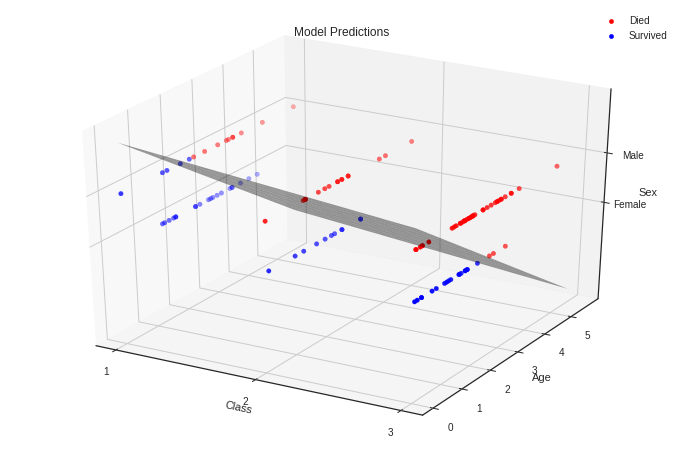

In [60]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

died = np.where(y_pred==0)[0]
survived = np.where(y_pred==1)[0]

p=ax.scatter(xs = X_test[died,0], ys =X_test[died,1], zs=X_test[died,2], 
             zdir='z', s=20, c='red',label = 'Died')
p=ax.scatter(xs = X_test[survived,0], ys =X_test[survived,1], zs=X_test[survived,2], 
             zdir='z', s=20, c='blue',label = 'Survived')

ax.set_xlabel('Class')
ax.set_ylabel('Age')
ax.set_zlabel('Sex')
ax.legend()
ax.set_title('Model Predictions')
ax.zaxis.set_ticks(np.unique(X_test[:,2]))
ax.zaxis.set_ticklabels(['Female','Male'])

ax.xaxis.set_ticks(np.unique(X_test[:,0]))
ax.xaxis.set_ticklabels(['1','2','3'])

ax.plot_surface(x_surf, y_surf,
                z_surf,
                rstride=1,
                cstride=1,
                color='None',
                alpha = 0.4)

plt.show()

## Visualizing our results (II)
Since we know what our model is predicting on each side of the decision boundary, we can color the points using the actual data. This will let us visualize where our model is failing.

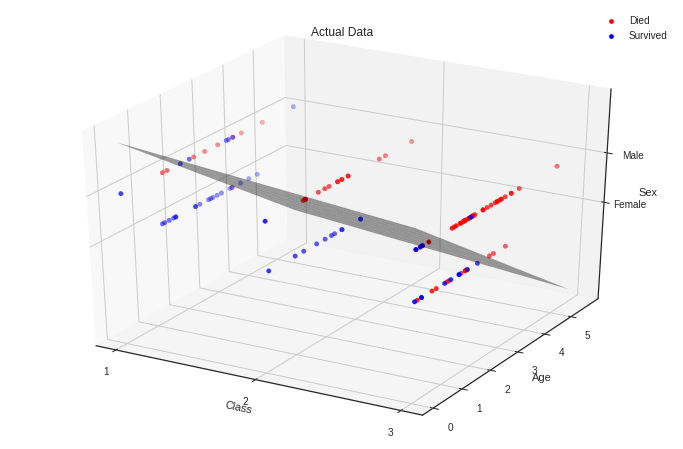

In [61]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

died = np.where(y_test==0)[0]
survived = np.where(y_test==1)[0]

p=ax.scatter(xs = X_test[died,0], ys =X_test[died,1], zs=X_test[died,2], 
             zdir='z', s=20, c='red',label = 'Died')
p=ax.scatter(xs = X_test[survived,0], ys =X_test[survived,1], zs=X_test[survived,2], 
             zdir='z', s=20, c='blue',label = 'Survived')

ax.set_xlabel('Class')
ax.set_ylabel('Age')
ax.set_zlabel('Sex')
ax.legend()
ax.set_title('Actual Data')
ax.zaxis.set_ticks(np.unique(X_test[:,2]))
ax.zaxis.set_ticklabels(['Female','Male'])

ax.xaxis.set_ticks(np.unique(X_test[:,0]))
ax.xaxis.set_ticklabels(['1','2','3'])

ax.plot_surface(x_surf, y_surf,
                z_surf,
                rstride=1,
                cstride=1,
                color='None',
                alpha = 0.4)

plt.show()

### And...

that's it! I hope you liked it. Please get in touch if you have any suggestions or comments.